### 建模第四次作业遇到线性规划问题
发现了一个解决线性规划很好用的库，`pulp`

#### 简单的例子：

In [1]:
#
import pulp as pp
from pulp import LpMaximize, LpVariable, LpInteger, LpProblem,LpStatus

prob = LpProblem("problem", LpMaximize)#定义求解最大值问题-->LpMinimize
x = LpVariable('x', 0, 6, LpInteger)   #定义变量
'''
这里第二，第三个参数分别为变量取值的上下限，第三个参数指定了变量是整型还是浮点
'''
y = LpVariable('y', 0, None, LpInteger)
#约束条件
prob += 400*x + 100*y
prob += 8*x + 10*y <= 80
prob += 2*x + 6*y <= 36
#问题表述存储
prob.writeLP('prob.lp')
prob.solve()
print("Status:", LpStatus[prob.status])#求解是否成功
for v in prob.variables():
    print(v.name, "=", v.varValue)

Status: Optimal
x = 6.0
y = 3.0


>正常来讲普通的线性规划求解都是没啥问题的
- lpSum():求和函数
- 枚举函数
    - allcombinations()
    - permutation()
    - allpermutations()
- [文档](https://www.coin-or.org/PuLP/index.html)还提供了组合优化和数度的例子

In [4]:
#婚礼就坐的例子，有点过分的解法,时间复杂度hhhhh
import pulp

max_tables = 5
max_table_size = 4
guests = 'A B C D E F G I J K L M N O P Q R'.split()

def happiness(table):
    """
    Find the happiness of the table
    - by calculating the maximum distance between the letters
    """
    return abs(ord(table[0]) - ord(table[-1]))
                
#枚举所有可能的就坐
possible_tables = [tuple(c) for c in pulp.allcombinations(guests, 
                                        max_table_size)]
# print('possibile table', possible_tables)
#create a binary variable to state that a table setting is used(一个就坐模式是否被使用)
x = pulp.LpVariable.dicts('table', possible_tables, 
                            lowBound = 0,
                            upBound = 1,
                            cat = pulp.LpInteger)
# print('x', x)
seating_model = pulp.LpProblem("Wedding Seating Model", pulp.LpMinimize)
# 优化目标是happy值累加，这里直接使用了所有可能种类
seating_model += sum([happiness(table) * x[table] for table in possible_tables])

#总的桌数限制
seating_model += sum([x[table] for table in possible_tables]) <= max_tables, \
                            "Maximum_number_of_tables"

#A guest must seated at one and only one table
for guest in guests:
    seating_model += sum([x[table] for table in possible_tables
                                if guest in table]) == 1, "Must_seat_%s"%guest
seating_model.solve()

print("The choosen tables are out of a total of %s:"%len(possible_tables))
for table in possible_tables:
    if x[table].value() == 1.0:
        print(table)

The choosen tables are out of a total of 3213:
('M', 'N')
('E', 'F', 'G')
('A', 'B', 'C', 'D')
('I', 'J', 'K', 'L')
('O', 'P', 'Q', 'R')


In [ ]:
from plup import allcombinations，permutation,allpermutations
#打印出来就知道区别了
c1 = allcombinations()
c2 = permutation()
c3 = allpermutations()

### scipy的优化--的确是没看到整数规划的设置
- 线性规划问题
- 和matlab比较像，函数为`linprog`
    - 返回的`status`  
        0：优化成功终止  
        1：达到迭代限制  
        2：问题似乎不可行  
        3：问题似乎没有限制
    - `nit`：迭代次数

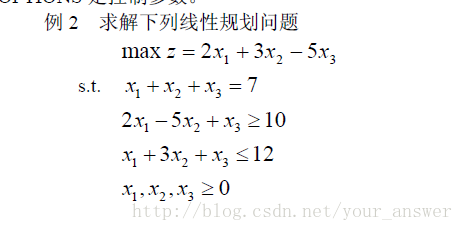

In [3]:
from scipy import optimize
import numpy as np

c = np.array([2, 3, -5])    #这个描述的是minmize对象
A_ub = np.array([
    [-2, 5, -1],
    [1, 3, 1]
])
B_ub = np.array([-10, 12])
A_eq = np.array([[1, 1, 1]])
B_eq = np.array([7])
x1 = (0, 7)
x2 = (0, 7)
x3 = (0, 7)
res = optimize.linprog(-c, A_ub, B_ub, A_eq, B_eq, bounds=(x1, x2, x3))
print(res)

     fun: -14.571428571428571
 message: 'Optimization terminated successfully.'
     nit: 2
   slack: array([3.85714286, 0.57142857, 6.42857143, 7.        , 0.        ])
  status: 0
 success: True
       x: array([6.42857143, 0.57142857, 0.        ])


## Scipy的optimize模块
- minimize：多标量函数优化
- 全局优化：basinhopping，differential_evolution
- 最小二乘法：least_squares
- 曲线拟合：curve_fit
- 单标量优化：minimize_scalar
- root finders:newton
- 多变量方程求根：root

### 大部分方法直接调用minimize就能实现
- `scipy`提供了`mminimize`方法[Link](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize)，在它上面有很多更专一的接口
    - 主要参数：
        - fun
        - x0:一个有价值的x0真的决定很多
        - method：可以调用的方法，挺多的，等学习数值优化再回来补充
        - bounds:一系列(min, max)
        - constraints:约束条件

In [2]:
import numpy as np
from scipy.optimize import minimize
from scipy import optimize

 ### 单变量，对于线性规划，特别是整数规划，直接使用前面的pulp库
 - scipy.optimize.minimize_scalar() 给出了一个一维标量最优化的通用接口

### 多变量标量函数的无约束优化

##### Nelder-Mead法
- 不是很懂，不需要任何梯度评估，因而可能需要更长时间，正常用于优化良好函数
- 优化对象：(Rosenbrock function)
<img src='imgs\3_1.png' width='300px' />

In [4]:
def f(x):   # rosenbrock函数
    return sum(100.0*(x[1:]-x[:-1]**2.0)**2.0 + (1-x[:-1])**2.0)

In [8]:
#使用minimize
x0 = np.array([1.3, 0.7, 0.8, 1.9, 1.2])
res = minimize(f, x0, method='nelder-mead', 
               options={'xtol':1e-8, 'disp':True})#定义迭代中x的绝对误差
print(res.x)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 339
         Function evaluations: 571
[1. 1. 1. 1. 1.]


In [11]:
#或者
optimize.fmin(f, [1.3, 0.7, 0.8, 1.9, 1.2], xtol=1e-8)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 339
         Function evaluations: 571


array([1., 1., 1., 1., 1.])

##### 简单共轭梯度下降方法(conjugate-gradient)

In [9]:
from scipy import optimize
import numpy as np

def fprime(x):
    return np.array((-2*.5*(1 - x[0]) - 4*x[0]*(x[1] - x[0]**2), 2*(x[1] - x[0]**2)))

optimize.fmin_cg(f, [1.3, 0.7, 0.8, 1.9, 1.2], fprime=fprime)  #这里不一定要指定导数，但指定有利于计算

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 8
         Function evaluations: 20
         Gradient evaluations: 20


array([0.99999649, 0.99999274])

##### 牛顿法和拟牛顿法


- 拟牛顿法:'BFGS':使用目标函数的梯度的方法，可以选择传入导数或者由算法估计
    - Rosenbrock函数的导数：
    <img src='imgs\3_2.png' width='400px' />
    端点处：
    <img src='imgs\3_3.png' width='400px' />

In [12]:
def rosen_der(x):
    '''返回导数列表'''
    xm = x[1:-1]
    xm_ml = x[:-2]
    xm_pl = x[2:]
    der = np.zeros_like(x)
    der[1:-1] = 200*(xm - xm_ml**2) - 400*xm*(xm_pl - xm**2) - 2*(1-xm)
    der[0] = -400*x[0]*(x[1] - x[0]**2) - 2*(1 - x[0])
    der[-1] = 200*(x[-1] - x[-2]**2)
    return der

In [14]:
res = minimize(f, x0, method='BFGS', jac=rosen_der,
              options={'disp':True})
print(res.x)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 25
         Function evaluations: 30
         Gradient evaluations: 30
[1.00000004 1.0000001  1.00000021 1.00000044 1.00000092]


In [16]:
# 另一种形式
optimize.fmin_bfgs(f, x0, fprime=rosen_der)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 25
         Function evaluations: 30
         Gradient evaluations: 30


array([1.00000004, 1.0000001 , 1.00000021, 1.00000044, 1.00000092])

- Newton-CG法：改进的牛顿法，通过二次型拟合；
    <img src='imgs/3_4.png' width='400px'>
    然后求解：
    <img src='imgs/3_5.png' width='400px'>
    Hessian矩阵的逆使用共轭梯度法进行计算，如果想完整地执行这个算法，必须提供Hessian矩阵，可以直接提供Hessian矩阵计算式或者用于产生Hessian矩阵的向量  
    比如例子的Rosenbrock函数的导数：
    <img src='imgs/3_6.png' width='600px'>
    边界处：
    <img src='imgs/3_7.png' width='600px'>
    <img src='imgs/3_8.png' width='600px'>

In [17]:
#Hessian矩阵，N=5
def rosen_hess(x):
    x = np.asarray(x)
    H = np.diag(-400*x[:-1], 1) + np.diag(-400*x[:-1], -1)
    diagonal = np.zeros_like(x)
    diagonal[0] = 1200 * x[0]**2 - 400*x[1] + 2
    diagonal[-1] = 200
    diagonal[1:-1] = 202  + 1200 * x[1:-1]**2 - 400*x[2:]
    H += np.diag(diagonal)
    return H

In [19]:
res = minimize(f, x0, method='Newton-CG',
              jac=rosen_der, hess=rosen_hess,
              options={'xtol':1e-8, 'disp':True})
print(res.x)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 24
         Function evaluations: 33
         Gradient evaluations: 56
         Hessian evaluations: 24
[1.         1.         1.         0.99999999 0.99999999]


In [24]:
#另一个形式
optimize.fmin_ncg(f, x0, fprime=rosen_der, 
                  fhess=rosen_hess, disp=True)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 21
         Function evaluations: 30
         Gradient evaluations: 50
         Hessian evaluations: 21


array([0.9999852 , 0.9999705 , 0.99994098, 0.99988173, 0.99976293])

In [25]:
# 不指定Hessian矩阵可以看到梯度评估增加了好多次
optimize.fmin_ncg(f, x0, fprime=rosen_der, 
                  disp=True)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 21
         Function evaluations: 30
         Gradient evaluations: 152
         Hessian evaluations: 0


array([0.99998222, 0.99996459, 0.99992918, 0.99985811, 0.99971558])

- 指定hess计算函数：在Newton_CG法中Hessian矩阵用来dot一个向量，因而可以通过`hess`函数直接提供相乘后的结果  
    比如Rosenbrocb函数：
    <img src='imgs/3_9.png' width='400px'>

In [26]:
def rosen_hess_p(x, p):
    x = np.array(x)
    Hp = np.zeros_like(x)
    Hp[0] = (1200*x[0]**2 - 400*x[1] + 2)*p[0] - 400*x[0]*p[1]
    Hp[1:-1] = -400*x[:-2]*p[:-2]+(202+1200*x[1:-1]**2-400*x[2:])*p[1:-1] \
                -400*x[1:-1]*p[2:]
    Hp[-1] = -400*x[-2]*p[-2] + 200*p[-1]
    return Hp

In [28]:
res = minimize(f, x0, method='Newton-CG',
              jac=rosen_der, hessp=rosen_hess_p,
              options={'xtol': 1e-8, 'disp': True})
print(res.x)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 24
         Function evaluations: 33
         Gradient evaluations: 56
         Hessian evaluations: 66
[1.         1.         1.         0.99999999 0.99999999]


- 信赖域Newton-CG法
    <img src='imgs/3_10.png' width='800px'>

In [ ]:
#Hessian 矩阵
res = minimize(rosen, x0, method='trust-ncg',
               jac=rosen_der, hess=rosen_hess,
               options={'gtol': 1e-8, 'disp': True})
#Hess函数
res = minimize(rosen, x0, method='trust-ncg',
               jac=rosen_der, hessp=rosen_hess_p,
               options={'gtol': 1e-8, 'disp': True})

- Trust_krylov法
    <img src='imgs/3_11.png' width='800px'/>

In [ ]:
#Hessian 矩阵
res = minimize(rosen, x0, method='trust-krylov',
               jac=rosen_der, hess=rosen_hess,
               options={'gtol': 1e-8, 'disp': True})
#Hess函数
res = minimize(rosen, x0, method='trust-krylov',
               jac=rosen_der, hessp=rosen_hess_p,
               options={'gtol': 1e-8, 'disp': True})

- Trust-exact法
<img src='imgs/3_12.png' width='800px'>

In [ ]:
res = minimize(rosen, x0, method='trust-exact',
               jac=rosen_der, hess=rosen_hess,
               options={'gtol': 1e-8, 'disp': True})

### 多元约束优化

- scipy 提供了**三种**约束方法，下面会具体介绍
- 问题形式：优化Rosenbrock函数：
    <img src='imgs/3_13.png' width='800px'>

- `trust-constr`,通过过`LinearConstraint`和`NolinearConstraint`定义约束条件
    - 约束的形式：
    <img src='imgs/3_14.png' width='800px'>

> 这里指定边界条件，然后给出线性和非线性约束的例子

In [40]:
from scipy.optimize import Bounds

bounds = Bounds([0, -0.5], [1.0, 2.0])

    线性约束条件：
<img src='imgs/3_15.png' width='800px'>

In [34]:
from scipy.optimize import LinearConstraint

linear_constraint = LinearConstraint([[1, 2], [2, 1]], [-np.inf, 1], [1, 1])

    非线性约束条件：
<img src='imgs/3_16.png' width='800px'>


In [2]:
from scipy.optimize import NonlinearConstraint
import numpy as np

def cons_f(x):
    return [x[0]**2 + x[1], x[0]**2 - x[1]]
def cons_J(x):
    return [[2*x[0], 1], [2*x[0], -1]]
def cons_H(x, v):
    return v[0]*np.array([[2, 0], [0, 0]]) + v[1]*np.array([[2, 0], [0, 0]])
nolinear_constraint = NonlinearConstraint(cons_f, -np.inf, 1, jac=cons_J, hess=cons_H)

对于Hessian矩阵难以给出的，目前推荐是使用`BFGS`和`SR1`,或者是使用有限差分
> **注意**：雅可比式也可以使用有限差分，但这时候需要**'由用户提供或使用上面的HessianUpdateStrategy'**

In [ ]:
from scipy.optimize import BFGS

nonlinear_constraint = NonlinearConstraint(cons_f, -np.inf, 1, jac=cons_J, hess=BFGS())

In [ ]:
nonlinear_constraint = NonlinearConstraint(cons_f, -np.inf, 1, jac=cons_J, hess='2-point')

nonlinear_constraint = NonlinearConstraint(cons_f, -np.inf, 1, jac='2-point', hess=BFGS())

>求解:

In [ ]:
x0 = np.array([.5, 0])
res = minimize(rosen, x0, method='trust-constr', jac=rosen_der, hess=rosen_hess,
              constraints=[linear_constraint, nolinear_constraint],
              options={'verbose':1}, bounds=bounds)
print(res.x)

>在求解时可以选择使用SR1():

In [ ]:
from scipy import SR1

res = minimize(rosen, x0, method='trust-constr', jac='2-point',
              hess=SR1(), constraints=[linear_constraint, nolinear_constraints],
              options={'verbose':1}, bounds=bounds)
print(res.x)

- `SLSQP`法  
解决的问题的形式：
<img src='imgs/3_17.png' width='800px'/>
约束项包含了线性和非线性，定义格式(**注意：**这里优化的依旧时之前那个函数)：

In [ ]:
ineq_cons = {
    'type':'ineq',
    'fun':lambda x:np.array([
        1 - x[0] - 2*x[1],
        1 - x[0]**2 - x[1],
        1 - x[0]**2 + x[1]
    ])
    'jac':lambda x:np.array([
        [1., 2.],
        [-2*x[0], -1.],
        [-2*x[0], 1.]
    ])
}
eq_cons = {'type': 'eq',
           'fun' : lambda x: np.array([2*x[0] + x[1] - 1]),
           'jac' : lambda x: np.array([2.0, 1.0])}

> 求解

In [ ]:
x0 = np.array([0.5, 0])
res = minimize(rosen, x0, method='SLSQP', jac=rosen_der,
               constraints=[eq_cons, ineq_cons], 
               options={'ftol': 1e-9, 'disp': True},bounds=bounds)
print(res.x)

https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html#tutorial-sqlsp

In [ ]:
#无约束优化的例子
from scipy.optimize import minimize
import numpy as np

local = np.array([
    [15, 85],
    [42, 145],
    [88, 145],
    [125, 140],
    [135, 125],
    [180, 18]
])
weight = np.array([160, 90, 105, 35, 60, 75])
#定义最小二乘优化目标
def func(point):
    dis = np.sum(np.square(local-point), axis=1)
    return np.sum(dis*weight)

x0 = np.sum(local, axis=0)/6
# print(list(x0))
res = minimize(func, x0, method='SLSQP')
print(res)

In [6]:
#有约束优化的例子
from scipy.optimize import minimize
fun = lambda x: (x[0] - 1)**2 + (x[1] - 2.5)**2
cons = ({'type': 'ineq', 'fun': lambda x:  x[0] - 2 * x[1] + 2},
         {'type': 'ineq', 'fun': lambda x: -x[0] - 2 * x[1] + 6},
         {'type': 'ineq', 'fun': lambda x: -x[0] + 2 * x[1] + 2})
bnds = ((0, None), (0, None))
res = minimize(fun, (2, 0), method='SLSQP', bounds=bnds,
                constraints=cons)
print(res)

     fun: 0.8000000011920985
     jac: array([ 0.80000002, -1.59999999])
 message: 'Optimization terminated successfully.'
    nfev: 13
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([1.4, 1.7])


### 全局优化算法

#### 暴力法
- `scipy.optimize.brute()`在函数网格内来评价函数，根据最小值返回参数。参数由`numpy.mgrid`给出的范围来指定。默认情况下，每个方向进行20步

In [14]:
def f(x):   # rosenbrock函数
    return .5*(1 - x[0])**2 + (x[1] - x[0]**2)**2
optimize.brute(f, ((-1, 2), (-1, 2)))

array([1.00001462, 1.00001547])

### 带约束的序列最小二乘
- 参数：
    - eqcons:(list) ==0
    - f_eqcons:(list) ==0,优先级更高
    - ieqcons:>=0
    - f_ieqcons:>=0
    - bounds
    - fprime
    - iter
    - acc

In [15]:
def f(x):
    return np.sqrt((x[0] - 3)**2 + (x[1] - 2)**2)

def constraint(x):
    return np.atleast_1d(1.5 - np.sum(np.abs(x)))

optimize.fmin_slsqp(f, np.array([0, 0]), ieqcons=[constraint, ])


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2.4748737350428893
            Iterations: 5
            Function evaluations: 20
            Gradient evaluations: 5


array([1.25004693, 0.24995307])